## Softmax Regression
Notes and experiments from http://machinelearningcoban.com/2017/02/17/softmax/

Logistic regression works perfectly with 2 classes. Though using it in combination with _one-vs-rest_ produces good classification, there are a few factors that are not mathematically reasonable. For example, the decision in which we label a record is backed up by the probability theory (we see the output layer as the respresentation of the probability it belongs to that class).

However, we could run into a problem that we have an output like $y = [0.8, 0.7]$, which means $P(x \in C_1) = 0.8, P(x \in C_2) = 0.7$. This is somehow unreasonable as $P(x \in C_1) + P(x \in C_2) = 1$ (if we have two classes).

As an alternative of _sigmoid function_, we use _softmax function_ which offers nicer properties, matching the probability model:

$\Sigma^K_{i=1}P(x \in C_i) = 1$ where $K$ is the number of classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(3)

# Random data
means = [[2, 2], [3, 8], [5, 4]]
cov = [[1, 0], [0, 1]]
N0, N1, N2 = 100, 100, 100
N = N0 + N1 + N2

X0 = np.random.multivariate_normal(means[0], cov, N0)
X1 = np.random.multivariate_normal(means[1], cov, N1)
X2 = np.random.multivariate_normal(means[2], cov, N2)
X = np.concatenate((X0, X1, X2), axis=0)
labels_original = np.array([0]*N0 + [1]*N1 + [2]*N2)

In [2]:
from scipy import sparse

def prepend_ones(X):
    return np.concatenate((np.ones((N, 1)), X), axis=1)

def convert_labels(y, C=None):
    if C is None:
        # Assume the class is indexed from zero. 0 = 1st class, 1 = 2nd class...
        C = y.max() + 1
    data = np.ones_like(y.T)
    row = np.arange(y.shape[0])
    col = y.T
    return sparse.coo_matrix((data, (row, col)), shape=(y.shape[0], C)).toarray()

# Format data
X = prepend_ones(X)
Y = convert_labels(labels_original)

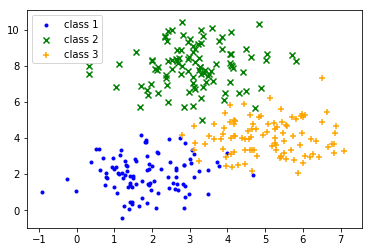

In [3]:
def display_data(X, labels, X_misclassified=None):
    X0 = X[np.where(labels == 0)[0], :]
    X1 = X[np.where(labels == 1)[0], :]
    X2 = X[np.where(labels == 2)[0], :]
    
    plt.scatter(X0[:, 1], X0[:, 2], color='blue', marker='.')
    plt.scatter(X1[:, 1], X1[:, 2], color='green', marker='x')
    plt.scatter(X2[:, 1], X2[:, 2], color='orange', marker='+')
    
    if X_misclassified is not None:
        plt.scatter(X_misclassified[:, 1], X_misclassified[:, 2], facecolors='none', edgecolors='red', s=60)
    
    plt.legend(['class 1', 'class 2', 'class 3', 'misclassified'])
    plt.show()

display_data(X, labels_original)

In [4]:
from numpy.linalg import linalg as LA
W_init = np.random.rand(X.shape[1], Y.shape[1]) # D x C

___Softmax function:___

$$f(z_i) = \frac{exp(z_i)}{\Sigma^C_{j=1}exp(z_j)}$$

To void _overflow_ when calculating $exp(z_i)$, we could transform $f(z_i)$ into:

$$f(z_i) = \frac{exp(z_i - c)}{\Sigma^C_{j=1}exp(z_j - c)}$$

In practice, we usually choose $c = max(z_i)$

In [5]:
def softmax(Z):
    eZ = np.exp(Z - np.max(Z, axis=1, keepdims = True))    
    eZ_sum = eZ.sum(axis=1).reshape(-1, 1)
    return eZ / eZ_sum

def h(X, W):
    return X.dot(W)

def cost(X, Y, W):
    A = softmax(h(X, W))
    return -np.sum(Y * np.log(A))

def grad(X, Y, W):
    A = softmax(h(X, W))
    E = A - Y
    return X.T.dot(E)

Computing ___gradient___ is vitally important but error-prone. We should check if the computation is correct by comparing with the result of ___numerical gradient___.

Note: We should only perform this check once (before training) since the computation of numerical gradient is highly expensive.

In [6]:
# Check gradient by comparing it with "numerical gradient"
def numerical_grad(X, Y, W, cost):
    eps = 1e-6
    g = np.zeros_like(W)
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W1 = W.copy()
            W2 = W.copy()
            W1[i, j] += eps 
            W2[i, j] -= eps
            g[i, j] = (cost(X, Y, W1) - cost(X, Y, W2))/(2*eps)
    return g 

g1 = grad(X, Y, W_init)
g2 = numerical_grad(X, Y, W_init, cost)
print('Norm:', LA.norm(g1 - g2))

Norm: 1.21436338898e-07


The norm is quite small --> We conclude that g1 and g2 are quite approximate, which means the _grad_ function is accurate.

We implement other steps of training similarly to logistic regression.

In [7]:
def has_converged(W, W_updated):
    return np.allclose(W, W_updated)
    
def softmax_regression(X, Y, W_init, eta=0.01, max_count=1000):
    W_history = [W_init] # d x k
    n, d = X.shape
    k = Y.shape[1]
    count = 0
    while count < max_count:
        mix_ids = np.random.permutation(N)
        for i in mix_ids:
            Xi = X[i, :].reshape((1, d)) # 1 x d
            Yi = Y[i, :].reshape((1, k)) # 1 x k
            ai = softmax(Xi.dot(W_history[-1]))
            
            W_updated = W_history[-1] - eta*grad(Xi, Yi, W_history[-1])
            
            if has_converged(W_history[-1], W_updated):
                return W_history, count
            
            W_history.append(W_updated)
        count += 1
    return W_history, count

def predict(X, W):
    return np.argmax(h(X, W), axis=1)

W_init = np.random.rand(X.shape[1], Y.shape[1])
W_history, count = softmax_regression(X, Y, W_init, eta=0.01, max_count=1000)
labels_predicted = predict(X, W_history[-1])

accuracy = np.double(labels_predicted == labels_original).mean()
print('Training done after {} iterations'.format(count))
print('Training accuracy:', accuracy*100)

Training done after 34 iterations
Training accuracy: 95.0


To make sure the cost function reaches the optimal, we plot the cost to check whether it decreases over time

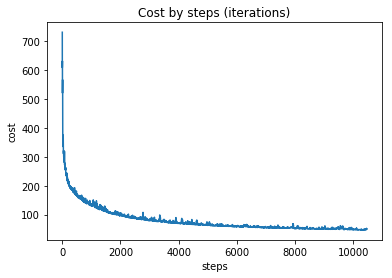

In [8]:
# Plot cost over iterations to check if the covergence took place
cost_history = []
for W in W_history:
    cost_history.append(cost(X, Y, W))

plt.plot(range(len(cost_history)), cost_history)
plt.title('Cost by steps (iterations)')
plt.xlabel('steps')
plt.ylabel('cost')
plt.show()

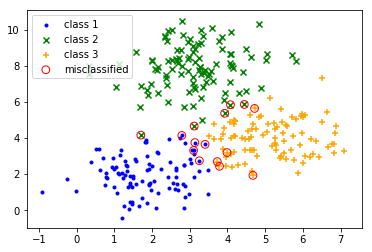

In [9]:
X_misclassified = X[np.argwhere(labels_predicted != labels_original).reshape(1, -1)[0]]
display_data(X, labels_predicted, X_misclassified)